# Notebook Information
----------------------
**Created By:**   Steven Bennett, Friedrich Hastedt

This is an example notebook for task 1. The goal of task 1 is to develop a model that is able to perform single-step retrosynthesis prediction. Specifically, the goal of the model is given a target molecule, the model should be able to predict a single reaction step that will produce the target molecule from one or more reagents.
The model will be evaluated in X different ways:

TODO 

From these evaluation metrics, we will provide a final score for each model, using a weighted average of the different metrics. The final score will be used to rank each team on the GitHub leaderboard.


## Notebook Contents
----------------------

In this notebook, we will show an example of using a pre-trained model as a starting point to generate the output file for submission to the competition. The notebook will cover the following steps:

1. Loading the pre-trained model, and performing data pre-processing steps
2. Generating predictions on the held-out test set and saving the output file
3. Performing a single fine-tuning step on the pre-trained model
4. Generating predictions using OpenAI-API to generate predictions using the GPT series of models

You are free to experiment with as many different models as you like, and this notebook only serves as an example of how to get started. You are free to use any other models that you like, including using ChatGPT to make prediction, and you are free to use any other data that you like. 
The only requirement is that the test set data is used to generate the output file for the submission.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from example_model import Model
from eval import TopK
from rdkit import Chem

/home/sbennett/miniconda3/envs/Datathon_LLM/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
model = Model(
    model_path="Models/USPTO50_model_step_500000.pt", 
)

FileNotFoundError: [Errno 2] No such file or directory: 'Models/USPTO50_model_step_500000.pt'

In [30]:
results = model.predict(
    source_path='Data/example_src_small.txt',
    num_predictions=10,
    batch_size=100,
    beam_size=10
)

/home/sbennett/mambaforge/envs/Datathon_LLM/lib/python3.6/site-packages/torchtext/data/field.py:359: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(arr, dtype=self.dtype, device=device)


PRED AVG SCORE: -0.0013, PRED PPL: 1.0013


In [31]:
targets = list(results.keys())

In [34]:
results

{'CC(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1': ['CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C',
  'CC(=O)c1ccc(NC(=O)OC(C)(C)C)cc1.CC(C)(C)[O-]',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.COC(=O)c1ccc2c(ccn2C(=O)OC(C)(',
  'CC(=O)c1ccc(NC(=O)OC(C)(C)C)cc1.CC(C)(C)[O-]',
  'CC(=O)c1ccc(NC(=O)OC(C)(C)C)cc1.CC(C)(C)[O-]'],
 'Cc1ccc(S(=O)(=O)O[C@@H]2CN(C(=O)OC(C)(C)C)[C@@H]3[C@@H](O)CO[C@@H]32)cc1': ['CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1ccc(S(=O)(=O)O[C@@H]2CN[C@@H]3[C@@H](O)CO[C@@H]32)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc

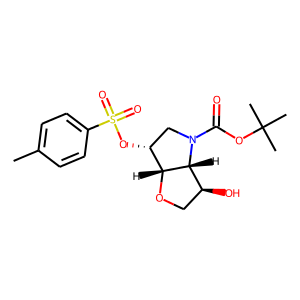

In [32]:
target_pos = 1
Draw.MolToImage(Chem.MolFromSmiles(targets[target_pos]))

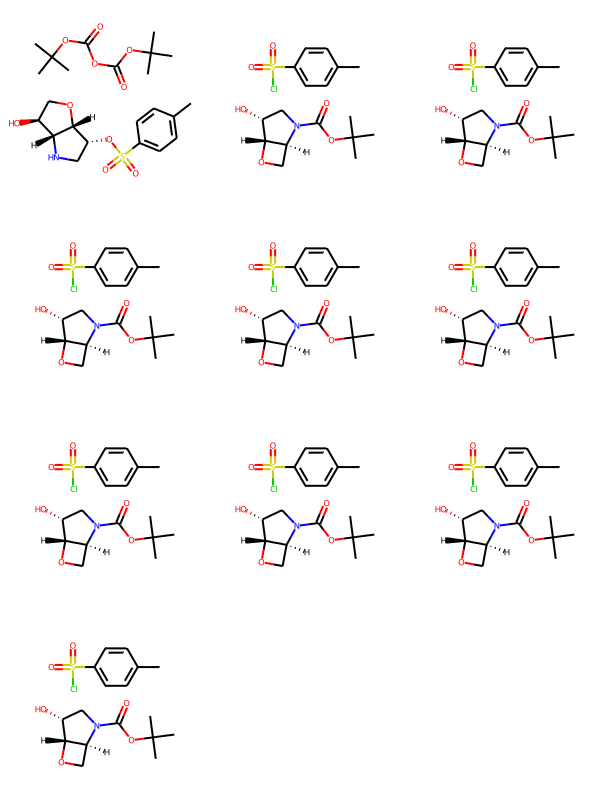

In [33]:
reactants = [Chem.MolFromSmiles(smi) for smi in results[targets[target_pos]]]
Draw.MolsToGridImage(reactants)

In [22]:
with open("/rds/general/user/sb2518/home/Postdoc/Datathon_LLM/Fred_Folder/Hackathon/example_notebooks/USPTO50/tgt-test.txt", 'r') as f:
    targets = f.read().replace(" ", "").split('\n')

FileNotFoundError: [Errno 2] No such file or directory: '/rds/general/user/sb2518/home/Postdoc/Datathon_LLM/Fred_Folder/Hackathon/example_notebooks/USPTO50/tgt-test.txt'

In [6]:
targets = {
    list(results.keys())[i]: targets[i]
    for i in range(len(results))
}

In [11]:
topk = TopK(k=10)

In [20]:
topk(results, targets)

RDKit ERROR: [13:30:22] SMILES Parse Error: syntax error while parsing: O=[N+](
RDKit ERROR: [13:30:22] SMILES Parse Error: Failed parsing SMILES 'O=[N+](' for input: 'O=[N+]('
RDKit ERROR: [13:30:22] SMILES Parse Error: syntax error while parsing: O=[N+](
RDKit ERROR: [13:30:22] SMILES Parse Error: Failed parsing SMILES 'O=[N+](' for input: 'O=[N+]('


ArgumentError: Python argument types in
    rdkit.Chem.rdmolfiles.MolToSmiles(NoneType)
did not match C++ signature:
    MolToSmiles(RDKit::ROMol mol, bool isomericSmiles=True, bool kekuleSmiles=False, int rootedAtAtom=-1, bool canonical=True, bool allBondsExplicit=False, bool allHsExplicit=False, bool doRandom=False)
    MolToSmiles(RDKit::ROMol mol, RDKit::SmilesWriteParams params)

In [70]:
targets

{'CC(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1': 'CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C',
 'Cc1ccc(S(=O)(=O)O[C@@H]2CN(C(=O)OC(C)(C)C)[C@@H]3[C@@H](O)CO[C@@H]32)cc1': 'CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1ccc(S(=O)(=O)O[C@@H]2CN[C@@H]3[C@@H](O)CO[C@@H]32)cc1',
 'CCOC(=O)c1nn(-c2ccc(Cl)cc2Cl)c(-c2ccc(OC)cc2)c1CBr': 'CCOC(=O)c1nn(-c2ccc(Cl)cc2Cl)c(-c2ccc(OC)cc2)c1C.O=C1CCC(=O)N1Br',
 'CC(C)(C)OC(=O)Nc1nc2c(-c3cccc([N+](=O)[O-])c3)cc(C#N)cc2s1': 'CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.N#Cc1cc(-c2cccc([N+](=O)[O-])c2)c2nc(N)sc2c1',
 'O=C(NCc1ccccc1S(=O)(=O)C1CC1)C(F)(F)F': 'NCc1ccccc1S(=O)(=O)C1CC1.O=C(OC(=O)C(F)(F)F)C(F)(F)F',
 'C[Si](C)(C)OC(=O)/C=C/CBr': 'C/C=C/C(=O)O[Si](C)(C)C.O=C1CCC(=O)N1Br',
 'CC(C)(C)OC(=O)N1CCc2oc3c(Cl)cc(S(=O)c4ccccc4)cc3c2C1': 'CC(C)(C)OC(=O)N1CCc2oc3c(Cl)cc(Sc4ccccc4)cc3c2C1.O=C(OO)c1cccc(Cl)c1',
 'CC(C)(C)OC(=O)n1cnc(C=O)c1': 'CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.O=Cc1c[nH]cn1',
 'Clc1cc(Cl)c(CBr)cn1': 'Cc1cnc(Cl)cc1Cl.O=C1CCC(=O)N1Br',
 'COc1nc2ccc(C(=O)c3cnnn3C)cc2c(Cl)c

In [56]:
results

{'CC(=O)c1ccc2c(ccn2C(=O)OC(C)(C)C)c1': ['CC(=O)c1ccc2[nH]ccc2c1.CC(C)(C)OC(=O)OC(=O)OC(C)(C)C',
  'CC(=O)c1ccc(NC(=O)OC(C)(C)C)cc1.CC(C)(C)[O-]',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.CON(C)C(=O)OC(C)(C)C',
  'CC(=O)c1ccc2[nH]ccc2c1.COC(=O)c1ccc2c(ccn2C(=O)OC(C)(',
  'CC(=O)c1ccc(NC(=O)OC(C)(C)C)cc1.CC(C)(C)[O-]',
  'CC(=O)c1ccc(NC(=O)OC(C)(C)C)cc1.CC(C)(C)[O-]'],
 'Cc1ccc(S(=O)(=O)O[C@@H]2CN(C(=O)OC(C)(C)C)[C@@H]3[C@@H](O)CO[C@@H]32)cc1': ['CC(C)(C)OC(=O)OC(=O)OC(C)(C)C.Cc1ccc(S(=O)(=O)O[C@@H]2CN[C@@H]3[C@@H](O)CO[C@@H]32)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc1',
  'CC(C)(C)OC(=O)N1C[C@@H](O)[C@H]2OC[C@@H]21.Cc1ccc(S(=O)(=O)Cl)cc